#**Introduction to PyTorch Part 2**



#**All General Imports**

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

#**All PyTorch Imports**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#**Softmax**

We need our network output a single scalar value (so n_out = 1), cast the labels to floats (0.0 for airplane and 1.0 for bird), and use those as a target for MSELoss (the average of squared differences in the batch). Doing so, we would cast the problem into a regression problem. However, looking more closely, we are now dealing with something a bit different in nature. We need to recognize that the output is categorical: it’s either a bird or an airplane (or something else if we had all 10 of the original classes in case of Cifa10). We have to represent a categorical variable, we should switch to a one-hot-encoding representation of that variable, such as [1, 0] for airplane or [0, 1] for bird (the order is arbitrary). This will still work if we have 10 classes, as in the full CIFAR-10 dataset; we’ll just have a vector of length 10.In the ideal case, the network would output torch.tensor([1.0, 0.0]) for an airplane and torch.tensor([0.0, 1.0]) for a bird. Practically speaking, since our classifier will not be perfect, we can expect the network to output something in between. The key realization in this case is that we can interpret our output as probabilities: the first entry is the probability of “airplane,” and the second is the probability of “bird.” Converting the problem in terms of probabilities imposes a few extra constraints on the outputs of our network: Each element of the output must be in the [0.0, 1.0] range (a probability of an outcome cannot be less than 0 or greater than 1). The elements of the output must add up to 1.0 (we’re certain that one of the two outcomes will occur). It sounds like a tough constraint to enforce in a differentiable way on a vector of numbers. Yet there’s a very smart trick that does exactly that, and it’s differentiable: it’s called softmax. Representing the output as probabilities, Softmax is a function that takes a vector of values and produces another vector of the same dimension, where the values satisfy the constraints we just listed to represent probabilities. That is, we take the elements of the vector, compute the elementwise exponential, and divide each element by the sum of exponentials:

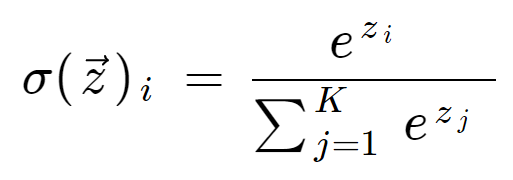

In [ ]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

x = torch.tensor([1.0, 2.0, 3.0])

print(softmax(x))
print(softmax(x).sum())

Softmax is a monotone function, in that lower values in the input will correspond to lower values in the output. However, it’s not scale invariant, in that the ratio between values is not preserved. In fact, the ratio between the first and second elements of the input is 0.5, while the ratio between the same elements in the output is 0.3678. This is not a real issue, since the learning process will drive the parameters of the model in a way that values have appropriate ratios. 

The nn module of PyTorch makes softmax available as a module. Since, as usual, input tensors may have an additional batch 0th dimension, or have dimensions along which they encode probabilities and others in which they don’t, **nn.Softmax** requires us to specify the dimension along which the softmax function is applied.


**nn.Softmax:** applies the Softmax function to an n-dimensional input Tensor rescaling them so that the elements of the n-dimensional output Tensor lie in the range [0,1] and sum to 1.

In [ ]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

#**Pytorch nn module**

**PyTorch** has a whole submodule dedicated to neural networks, called torch.nn. It contains the building blocks needed to create all sorts of neural network architectures. Those building blocks are called modules in PyTorch (such building blocks are often referred to as layers in other frameworks). A PyTorch module is a Python class deriving from the nn.Module base class. A module can have one or more Parameter instances as attributes, which are tensors whose values are optimized during the training process (think w and b in our linear model). A module can also have one or more submodules (subclasses of nn.Module) as attributes, and it will be able to track their parameters as well. Unsurprisingly, we can find a subclass of nn.Module called **nn**.**Linear**, which applies an affine transformation to its input (via the parameter attributes weight and bias) and is equivalent to Dense layers without activation layer in Keras.


All PyTorch-provided subclasses of **nn.Module** have their __call__ method defined. This allows us to instantiate an nn.Linear and call it as if it was a function. 

In [ ]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape

torch.Size([11, 1])

In [ ]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 2,  0, 10,  1,  7,  3,  8,  4,  6]), tensor([9, 5]))

In [ ]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

**nn.Linear:** applies a linear transformation to the incoming data: y = xA^T + b. https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

The constructor to nn.Linear accepts three arguments: the number of input features, the number of output features, and whether the linear model includes a bias or not (defaulting to True, here). 

In [ ]:
import torch.nn as nn
linear_model = nn.Linear(1, 1)
linear_model(t_un_val)

tensor([[-2.1046],
        [-1.8615]], grad_fn=<AddmmBackward0>)

Calling an instance of nn.Module with a set of arguments ends up calling a method named forward with the same arguments. The forward method is what executes the forward computation, while __call__ does other rather important chores before and after calling forward. So, it is technically possible to call forward directly, and it will produce the same output as __call__, but this should not be done from user code:

In [ ]:
y = model(x)       
y = model.forward(x)

#**Initializations**

In [3]:
torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

#**Globals**

In [4]:
data_path = './'
model_path = './'
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

#**Hyper-parameters**

In [18]:
n_epochs = 4
learning_rate = 1e-2
n_out = 2

#**Datasets Downloads**

In [6]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [7]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [8]:
len(cifar10)

50000

In [9]:
len(cifar10_val)

10000

#**Data Preparation**

We are willing to discriminate between **airplanes** and **birds** in order to detect them during the flight, for example. 

So we create subclasses that only includes birds and airplanes. So we take a shortcut and just filter the data in cifar10 and remap the labels so they are contiguous. 

In [10]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

We then create a **cifar2** object which satisfies the basic requirements for a Dataset--that is, __len__ and __getitem__ are defined--so we’re going to use that. We should be aware, however, that this is a clever shortcut and we might wish to implement a proper Dataset if we hit limitations with it. 

In [11]:
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

#**Fully Connected Layers**

#**Model Definition**

Number of Features:**32 × 32 × 3** which is **3,072** input features per sample. Our model is an nn.Linear with 3,072 input features and some number of hidden features, followed by an activation, and then another nn.Linear that tapers the network down to an appropriate output number of features (2, for this use case). We create 512 hidden features. A neural network like an MLP (Multi Layer Perceptron) needs at least one hidden layer (of activations, so two modules) with a nonlinearity in between in order to be able to learn arbitrary functions, it would just be a linear model. 

**nn.Sequential:** represents a **Sequential** container. The value a Sequential provides over manually calling a sequence of modules is that it allows treating the whole container as a single module, such that performing a transformation on the Sequential applies to each of the modules it stores. https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

**nn.Tanh:** applies the Hyperbolic Tangent (Tanh) function element-wise. https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html

The **hidden features** represent "learned" relations between the inputs encoded through the weight matrix. As such, the model might learn to “compare” vector elements 176 and 208, but it does not a priori focus on them because it is structurally unaware that these are, indeed (row 5, pixel 16) and (row 6, pixel 16), and thus adjacent. So we have a model. 

In [12]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Let’s do it, just to see what comes out. We first build a batch of one image, our bird

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


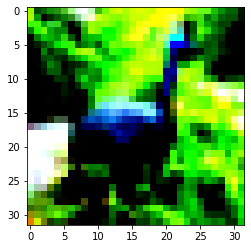

In [13]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In order to call the model, we need to make the input have the right dimensions. We recall that our model expects 3,072 features in the input, and that nn works with data organized into batches along the zeroth dimension. So we need to turn our 3 × 32 × 32 image into a 1D tensor and then add an extra dimension in the zeroth position. 

In [14]:
img_batch = img.view(-1).unsqueeze(0)

Now we can call our model. So, we get probabilities. At moment, the weights and biases of our linear layers have not been trained at all. Their elements are initialized randomly by PyTorch between -1.0 and 1.0. Interestingly, we also see grad_fn for the output, which is the tip of the backward computation graph In addition, while we know which output probability is supposed to be which (recall our class_names), our network has no indication of that. Is the first entry “airplane” and the second “bird,” or the other way around? The network can’t even tell that at this point. It’s the loss function that associates a meaning with these two numbers, after backpropagation. 

In [15]:
out = model(img_batch)
out

tensor([[0.3700, 0.6300]], grad_fn=<SoftmaxBackward0>)

Thus, after training, we will be able to get the label as an index by computing the argmax of theoutput probabilities: that is, the index at which we get the maximum probability. Conveniently, when supplied with a dimension, torch.max returns the maximum element along that dimension as well as the index at which that value occurs. In our case, we need to take the max along the probability vector (not across batches), therefore, dimension 1. 

In [16]:
_, index = torch.max(out, dim=1)

index

tensor([1])

#**Model Training**

We apply changes to parameters based on a very partial estimation of the gradient on a single sample. However, what is a good direction for reducing the loss based on one sample might not be a good direction for others. By shuffling samples at each epoch and estimating the gradient on one or (preferably, for stability) a few samples at a time, we are effectively introducing randomness in our gradient descent. SGD stands for stochastic gradient descent, and this is what the S is about: working on small batches (aka minibatches) of shuffled data. It turns out that following gradients estimated over minibatches, which are poorer approximations of gradients estimated across the whole dataset, helps convergence and prevents the optimization process from getting stuck in local minima it encounters along the way. Gradients from minibatches are randomly off the ideal trajectory, which is part of the reason why we want to use a reasonably small learning rate. Shuffling the dataset at each epoch helps ensure that the sequence of gradients estimated over minibatches is representative of the gradients computed across the full dataset. Typically, minibatches are a constant size that we need to set prior to training, just like the learning rate. These are the hyperparameters, to distinguish them from the parameters of a model.


**nn.NLLLoss**:The negative log likelihood loss. It is useful to train a classification problem with C classes. Obtaining log-probabilities in a neural network is easily achieved by adding a LogSoftmax layer in the last layer of your network. You may use CrossEntropyLoss instead, if you prefer not to add an extra layer. https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

In [19]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 2.808479
Epoch: 1, Loss: 2.832569
Epoch: 2, Loss: 5.176270
Epoch: 3, Loss: 5.776686


In our previous training code, we chose minibatches of size 1 by picking one item at a time from the dataset. The torch.utils.data module has a class that helps with shuffling and organizing the data in minibatches: **DataLoader**. The job of a data loader is to sample minibatches from a dataset, giving us the flexibility to choose from different sampling strategies. A very common strategy is uniform sampling after shuffling the data at each epoch.

At each inner iteration, imgs is a tensor of size 64 × 3 × 32 × 32--that is, a minibatch of 64 (32 × 32) RGB images--while labels is a tensor of size 64 containing label indices.

At a minimum, the **DataLoader** constructor takes a Dataset object as input, along with batch_size and a shuffle Boolean that indicates whether the data needs to be shuffled at the beginning of each epoch:

In [20]:
train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)

The combination of nn.LogSoftmax and nn.NLLLoss is equivalent to using nn.CrossEntropyLoss. This terminology is a particularity of PyTorch, as the nn.NLLoss computes, in fact, the cross entropy but with log probability predictions as inputs where nn.CrossEntropyLoss takes scores (sometimes called logits). Technically, nn.NLLLoss is the cross entropy between the Dirac distribution, putting all mass on the target, and the predicted distribution given by the log probability inputs.

In [21]:
model = nn.Sequential(
            nn.Linear(3072, 128),           # after training check with 512
            nn.Tanh(),
            nn.Linear(128, 2),
            nn.LogSoftmax(dim=1))

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.572484
Epoch: 1, Loss: 0.428618
Epoch: 2, Loss: 0.478573
Epoch: 3, Loss: 0.493837


We can compute the accuracy of our model on the training set and validation set in terms of the number of correct classifications over the total.

**torch.no_grad():** Context-manager that disabled gradient calculation.Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward()

In [22]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.817600


In [23]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.806000


This cross entropy can be interpreted as a negative log likelihood of the predicted distribution under the target distribution as an outcome. So both losses are the negative log likelihood of the model parameters given the data when our model predicts the (softmax-applied) probabilities.

In [24]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.385799
Epoch: 1, Loss: 0.542206
Epoch: 2, Loss: 0.578028
Epoch: 3, Loss: 0.503629


In [25]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.806400


In [26]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.799500


PyTorch offers a quick way to determine how many parameters a model has through the parameters() method of nn.Model (the same method we use to provide the parameters to the optimizer). To find out how many elements are in each tensor instance, we can call the numel method. Summing those gives us our total count. Depending on our use case, counting parameters might require us to check whether a parameter has requires_grad set to True, as well. We might want to differentiate the number of trainable parameters from the overall model size.

In [27]:
sum([p.numel() for p in model.parameters()])

3737474

In [28]:
sum([p.numel() for p in nn.Linear(3072, 512).parameters()])

1573376

#**Convolutional Layers**

The torch.nn module provides convolutions for 1, 2, and 3 dimensions: **nn.Conv1d** for time series, **nn.Conv2d** for images, and **nn.Conv3d** for volumes or videos.


At a minimum, the arguments we provide to nn.Conv2d are the number of input features (or channels, since we’re dealing with multichannel images: that is, more than one value per pixel), the number of output features, and the size of the kernel. For instance, for our first convolutional module, we’ll have 3 input features per pixel (the RGB channels) and an arbitrary number of channels in the output--say, 16. The more channels in the output image, the more the capacity of the network. We need the channels to be able to detect many different types of features. Also, because we are randomly initializing them, some of the features we’ll get, even after training, will turn out to be useless.2 Let’s stick to a kernel size of 3 × 3.It is very common to have kernel sizes that are the same in all directions, so PyTorch has a shortcut for this: whenever kernel_size=3 is specified for a 2D convolution, it means 3 × 3 (provided as a tuple (3, 3) in Python).

In [29]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out
    
model = Net()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs)
        loss = loss_fn(outputs, labels)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))


Epoch: 0, Loss: 0.620399
Epoch: 1, Loss: 0.402316
Epoch: 2, Loss: 0.225405
Epoch: 3, Loss: 0.305665


In [30]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.839800


In [31]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.838500


In [32]:
model = Net()
sum([p.numel() for p in model.parameters()])

18090

#**Display Validation Accuracy for each epoch**

In [36]:
model = Net()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

for epoch in range(n_epochs):
    for (imgs, labels), (val_imgs, val_labels) in zip(train_loader, val_loader):
        outputs = model(imgs)
        val_outputs = model(val_imgs)
        loss = loss_fn(outputs, labels)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #Accuracy
    val_outputs = (val_outputs > 0.5).float()
    correct = (val_outputs == val_labels).float().sum()
    print("Epoch: %d, Loss: %f Accuracy: %f" % (epoch, float(loss), correct/val_cifar2.shape[0]))

RuntimeError: ignored

#**Mnist Training**

In [37]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(data_path, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()#,
                       #transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [39]:
model = Net()

In [40]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [41]:
for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
    print('Current loss', float(loss))

Current loss 0.4957163333892822
Current loss 0.2549054026603699
Current loss 0.22899316251277924
Current loss 0.3364781141281128
Current loss 0.09036285430192947
Current loss 0.19089177250862122
Current loss 0.06591050326824188
Current loss 0.3240581154823303
Current loss 0.23053310811519623
Current loss 0.1638336330652237


In [42]:
torch.save(model.state_dict(), model_path+'mnist.pth')

In [43]:
pretrained_model = Net()
pretrained_model.load_state_dict(torch.load(model_path+'mnist.pth'))

<All keys matched successfully>